In [1]:
import KNNclassy
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from sklearn.neighbors import NearestNeighbors
importlib.reload(KNNclassy)

<module 'KNNclassy' from '/home/miquelmiravet/University/Doctorat/Projects/IPAM_ML/KNN_miq/KNNclassy.py'>

In [54]:
def PBAYESIAN(algo, thr,kk):
    
    neigh = NearestNeighbors(n_neighbors=kk)
    neigh.fit(algo.xtrain)
    
    allprob = algo.metrics["probab"]
    
    total_events = len(algo.label_test)
    v_prob_NS = allprob[:,1]
    v_prob_REM = allprob[:,2]
    v_prob_both = allprob[:,1]+allprob[:,2]
 #   nplus_NS = v_prob_NS*kk
 #   nplus_REM = v_prob_REM*kk
 #   nplus_both = v_prob_both*kk
    nplus_NS = np.zeros(total_events)
    nplus_REM = np.zeros(total_events)
    nplus_both = np.zeros(total_events)

    for i in range(0,total_events):
        closestn = neigh.kneighbors(algo.xtest[i].reshape(1, -1),n_neighbors=kk,return_distance = False)
        labels = algo.label_train[closestn][0].tolist()
        for ll in range(0,len(labels)): 
            labels[ll] = int(labels[ll])
        nplus_NS[i] = int(labels.count(1))
        nplus_REM[i] = int(labels.count(2))
        nplus_both[i] = int(labels.count(1)+labels.count(2))
         
        
    events_have_NS = np.where((algo.label_test==1))[0]
    index_say_yes = np.where(v_prob_NS>=thr)[0]
    index_say_no  = np.where(v_prob_NS <thr)[0]
    count_NS = np.zeros(total_events)
    count_noNS = np.zeros(total_events)
    
    for i in range(0,total_events):
        if i in index_say_yes:
            if i in events_have_NS:
                count_NS[i] = 1
            elif i not in events_have_NS:
                count_NS[i] = 0
        elif i in index_say_no:
            if i in events_have_NS:
                count_NS[i] = 0
            elif i not in events_have_NS:
                count_NS[i] = 1  
                
    TP_NS = []
    FP_NS = []
    
    for i in range(0,int(kk+1)):
        indices = np.where(nplus_NS == i)
        events_n = count_NS[indices]
        TP_NS.append(np.sum(events_n))
       # events_nfalse = count_noNS[indices]
        FP_NS.append(len(events_n)-np.sum(events_n))
        
    TP_NS = np.array(TP_NS)
    FP_NS = np.array(FP_NS)
        
    events_have_REM = np.where(algo.label_test==2)[0]
    index_say_yes = np.where(v_prob_REM>=thr)[0]
    index_say_no  = np.where(v_prob_REM <thr)[0]
    count_REM = np.zeros(total_events)
    count_noREM = np.zeros(total_events)
    
    for i in range(0,total_events):
        if i in index_say_yes:
            if i in events_have_REM:
                count_REM[i] = 1
            elif i not in events_have_REM:
                count_REM[i] = 0
  #      elif i in index_say_no:
  #          if i in events_have_REM:
  #              count_REM[i] = 0
  #          elif i not in events_have_REM:
  #              count_REM[i] = 1       
    
    TP_REM = []
    FP_REM = []
    
    for i in range(0,int(kk+1)):
        indices = np.where(nplus_REM == i)
        events_n = count_REM[indices]
     #   events_nfalse = count_noREM[indices]
        TP_REM.append(np.sum(events_n))
        FP_REM.append(len(events_n)-np.sum(events_n))
    
    TP_REM = np.array(TP_REM)
    FP_REM = np.array(FP_REM)
    

    events_have_both = np.where((algo.label_test==1)|(algo.label_test==2))[0]
    index_say_yes = np.where(v_prob_both>=thr)[0]
    index_say_no  = np.where(v_prob_both <thr)[0]
    count_both = np.zeros(total_events)
    count_noboth = np.zeros(total_events)
    
    for i in range(0,total_events):
        if i in index_say_yes:
            if i in events_have_both:
                count_both[i] = 1
            elif i not in events_have_both:
                count_both[i] = 0
    #    elif i in index_say_no:
    #        if i in events_have_both:
    #            count_both[i] = 0
    #        elif i not in events_have_both:
    #            count_both[i] = 1       
    
    TP_both = []
    FP_both = []
    
    for i in range(0,int(kk+1)):
        indices = np.where(nplus_both == i)
        events_n = count_both[indices]
     #   events_nfalse = count_noboth[indices]
        TP_both.append(np.sum(events_n))
        FP_both.append(len(events_n)-np.sum(events_n))
    
    TP_both = np.array(TP_both)
    FP_both = np.array(FP_both)

    Pbayes_hasNS = (TP_NS)/(TP_NS+FP_NS)

    Pbayes_hasREM = (TP_REM)/(TP_REM+FP_REM)
            
    Pbayes_hasBOTH = (TP_both)/(TP_both+FP_both)
    
   # Pbayes_hasNS_v2 = (TP_NS+TP_REM)/(TP_NS+FP_NS+TP_REM+FP_REM)
        
    #-Pbayes_hasBOTH
    
    return Pbayes_hasBOTH, Pbayes_hasREM

In [55]:
from scipy.optimize import curve_fit

def sigmoid_mar(x, a, b):    #worse for some REM, better for NS
    #domain [0,1], scale if necessary
    return (np.exp(a*b)-np.exp(-a*(x-b)))*(1+np.exp(-a*(1-b)))/((1+np.exp(-a*(x-b)))*(np.exp(a*b)-np.exp(-a*(1-b))))

def sigmoid(x ,x0, k):
    L = 1
    b = 0
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)


def fit_bayesian(KNNdic,xdata): 
    
    p0 = [np.median(xdata),1]

   # p0 = [8,0.8]
    #REM
    popt, pcov = curve_fit(sigmoid, xdata, KNNdic['Pbayes_REM'], p0, method = 'lm')
    KNNdic['sigmoid_REM'] = popt
    #NS
    popt, pcov = curve_fit(sigmoid, xdata, KNNdic['Pbayes_NS'], p0, method = 'lm')
    KNNdic['sigmoid_NS'] = popt

In [56]:
frac_testing = 0.3
nneigh = [10]
pathClassy = "/home/miquelmiravet/University/Doctorat/Projects/IPAM_ML/KNN_miq/"
pathData = "/home/miquelmiravet/University/Doctorat/Projects/IPAM_ML/KNN_miq/input/"
EOS = ["APR4_EPP", "BHF_BBB2", "H4", "HQC18", "KDE0V", "KDE0V1", "MPA1", "MS1_PP", "MS1B_PP", "RS", "SK255", "SK272", "SKI2", "SKI3", "SKI4", "SKI5", "SKI6", "SKMP", "SKOP", "SLy", "SLY2", "SLY9", "SLY230A"]
EOSgrey = ["APR4_EPP",  "H4", "HQC18", "KDE0V", "KDE0V1", "MPA1", "MS1B_PP", "RS", "SK255", "SK272", "SKI2", "SKI3", "SKI4", "SKI5", "SKI6", "SKMP", "SKOP", "SLY2", "SLY9", "SLY230A"]
EOScolor = ["BHF_BBB2", "MS1_PP", "SLy"]
color_v = ['orange', 'green', 'blue']
BayesFactor = [1.526, 1.555, 0.056, 1.422, 1.177, 1.283, 0.276, 0.001, 0.009, 0.176, 0.179, 0.159, 0.108, 0.107, 0.33, 0.025, 0.288, 0.29, 0.618, 1.0, 1.028, 0.37, 0.932]

In [57]:
EOSdic = {}
sig_dic = {}
count = 0
#EOS = ['SLy']

In [58]:
for eos in EOS:
    
    print("Doing", eos)
    print('*'*60)

    for kk in nneigh:
        
        print("Nº of neighbors: ", kk)
        print('-'*40)

        KNN = KNNclassy.ClassificationKNN()
        KNN.load_original_dataset(pathData,eos+"/EMB/original_data_"+eos+"_s300_f0d7.csv",frac_testing)
    
        KNN.loadModel(pathClassy+"optimal_models_final/", "knn_3cat_grid_eos_"+eos)
        new_dic = {}
        new_dic['knn'] = KNN
        new_dic['bayes'] = BayesFactor[count]
        EOSdic[eos] = new_dic
   
        KNN.compute_metrics()

        EOSdic[eos]['score'] = KNN.metrics['score']
        params_model = KNN.model.get_params()
        EOSdic[eos]['n_neigh'] = params_model.get('n_neighbors')
        EOSdic[eos]['metric'] = params_model.get('metric')
        EOSdic[eos]['algo'] = params_model.get('algorithm')
        EOSdic[eos]['weight'] = params_model.get('weights')
    
        print('*'*60)
        
    count = count + 1
        

Doing APR4_EPP
************************************************************
Nº of neighbors:  10
----------------------------------------
File shape :  (198961, 11)
[ 1.006907  1.726921  1.172679 ... 79.196968 66.51236  59.432453]
************************************************************
Loading data...
Nº of features:  5
Nº of events:  198961
Nº of events for training:  139273
Nº of events for testing:  59688
Datasets loaded!
************************************************************
loading  /home/miquelmiravet/University/Doctorat/Projects/IPAM_ML/KNN_miq/optimal_models_final/knn_3cat_grid_eos_APR4_EPP.joblib
Model score :  0.9530558906312827
Predicting probabilities...
Testing time (s) :  1.9761234680190682
************************************************************
Doing BHF_BBB2
************************************************************
Nº of neighbors:  10
----------------------------------------
File shape :  (193624, 11)
[ 1.006907  1.726921  1.172679 ... 79.196968 66.5

Model score :  0.9460031229537098
Predicting probabilities...
Testing time (s) :  1.92246452299878
************************************************************
Doing SK272
************************************************************
Nº of neighbors:  10
----------------------------------------
File shape :  (201120, 11)
[ 1.006907  1.726921  1.172679 ... 79.196968 66.51236  59.432453]
************************************************************
Loading data...
Nº of features:  5
Nº of events:  201120
Nº of events for training:  140784
Nº of events for testing:  60336
Datasets loaded!
************************************************************
loading  /home/miquelmiravet/University/Doctorat/Projects/IPAM_ML/KNN_miq/optimal_models_final/knn_3cat_grid_eos_SK272.joblib
Model score :  0.9454885971890745
Predicting probabilities...
Testing time (s) :  2.0653608220163733
************************************************************
Doing SKI2
*************************************************

Model score :  0.9488468758380263
Predicting probabilities...
Testing time (s) :  2.027451221831143
************************************************************
Doing SLY230A
************************************************************
Nº of neighbors:  10
----------------------------------------
File shape :  (197359, 11)
[ 1.006907  1.726921  1.172679 ... 79.196968 66.51236  59.432453]
************************************************************
Loading data...
Nº of features:  5
Nº of events:  197359
Nº of events for training:  138152
Nº of events for testing:  59207
Datasets loaded!
************************************************************
loading  /home/miquelmiravet/University/Doctorat/Projects/IPAM_ML/KNN_miq/optimal_models_final/knn_3cat_grid_eos_SLY230A.joblib
Model score :  0.9502085902004831
Predicting probabilities...
Testing time (s) :  1.9607393089681864
************************************************************


In [59]:
n_k = np.arange(0,kk+1)
n_k = n_k/max (n_k)
for eos in EOS:
    EOSdic[eos]['Pbayes_NS'],EOSdic[eos]['Pbayes_REM'] = PBAYESIAN(EOSdic[eos]['knn'],0.5,kk)
    fit_bayesian(EOSdic[eos],n_k)

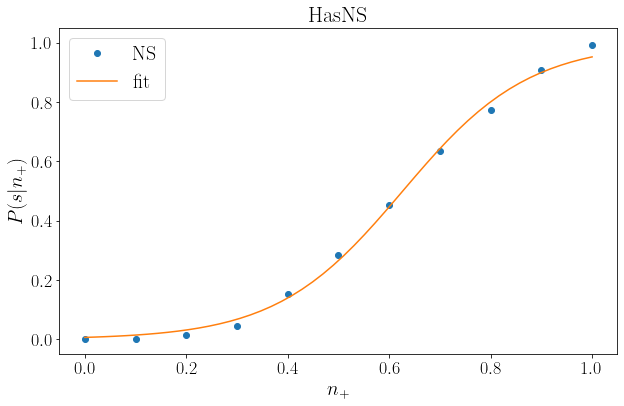

In [60]:
x = np.linspace(0, 1, 50)
y = sigmoid(x,EOSdic['SLy']['sigmoid_NS'][0],EOSdic['SLy']['sigmoid_NS'][1])

plt.figure(figsize=(10,6))
plt.plot(n_k, EOSdic['SLy']['Pbayes_NS'], 'o', label='NS')
plt.title('HasNS', fontsize = 22)
plt.xlabel(r'$n_+$', fontsize = 20)
plt.ylabel(r'$P(s|n_+)$', fontsize = 20)
plt.plot(x,y, label='fit')
plt.ylim(-0.05, 1.05)
#plt.plot(n_k, EOSdic['SLy']['Pbayes_REM'], 'o', label='REM')
plt.legend(loc='best', fontsize = 20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

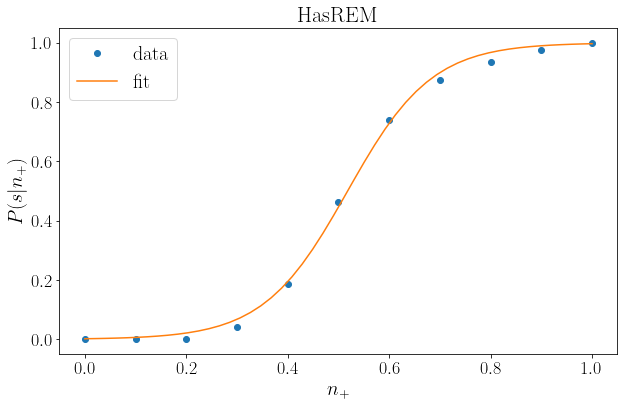

In [61]:
x = np.linspace(0, 1, 50)
y = sigmoid(x,EOSdic['SLy']['sigmoid_REM'][0],EOSdic['SLy']['sigmoid_REM'][1])

plt.figure(figsize=(10,6))
plt.plot(n_k, EOSdic['SLy']['Pbayes_REM'], 'o', label='data')
plt.title('HasREM', fontsize = 22)
plt.xlabel(r'$n_+$', fontsize = 20)
plt.ylabel(r'$P(s|n_+)$', fontsize = 20)
plt.plot(x,y, label='fit')
plt.ylim(-0.05, 1.05)
#plt.plot(n_k, EOSdic['SLy']['Pbayes_REM'], 'o', label='data')
plt.legend(loc='best', fontsize = 20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

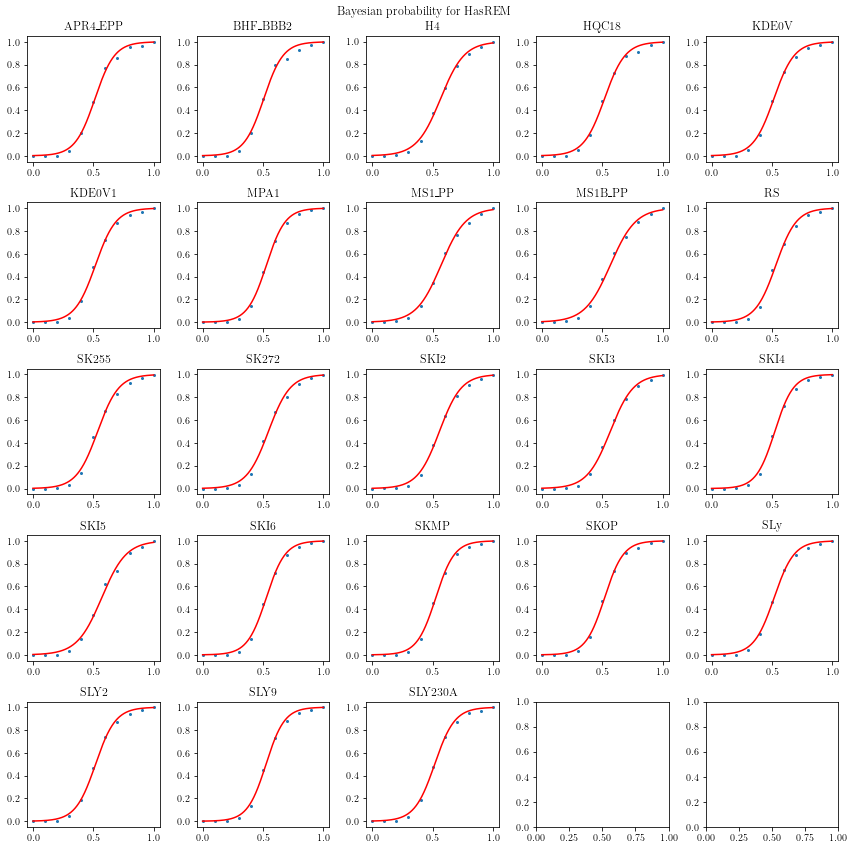

In [62]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12,12))
i = 0; j = 0;
for eos in EOS:
    axes[i,j].scatter(n_k, EOSdic[eos]['Pbayes_REM'], s=4)
    axes[i,j].plot(np.linspace(0,1,500), sigmoid(np.linspace(0,1, 500), EOSdic[eos]['sigmoid_REM'][0], EOSdic[eos]['sigmoid_REM'][1]), c='red')
    axes[i,j].set_title(eos)
    j = j + 1
    if (j > 4):
        j=0
        i=i+1
_=fig.suptitle("Bayesian probability for HasREM")
fig.tight_layout() 

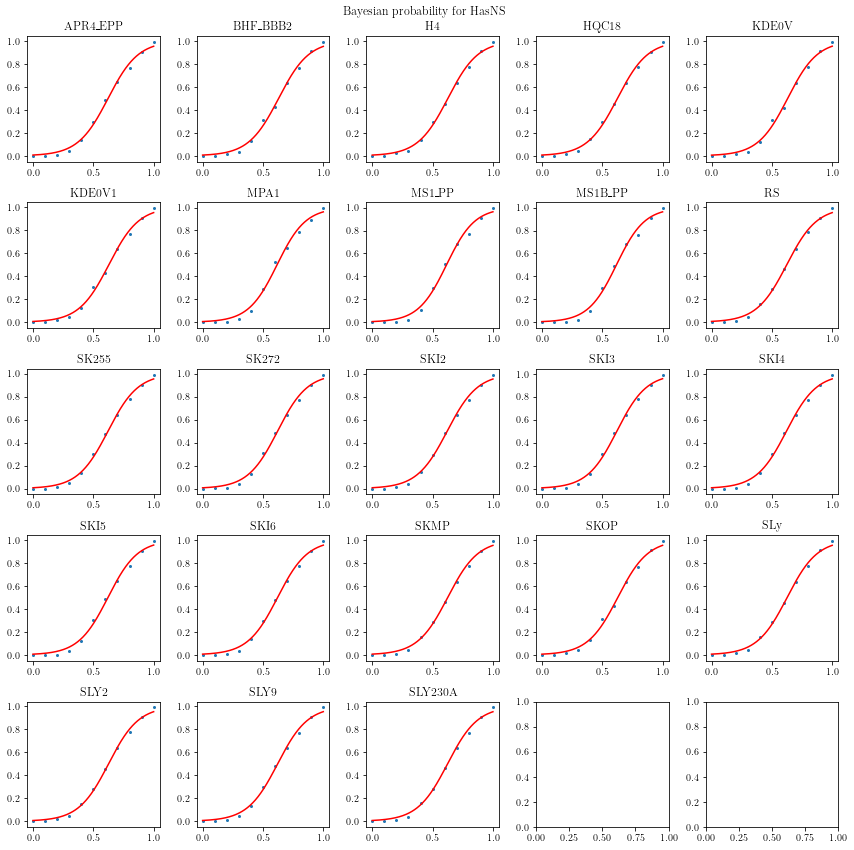

In [63]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12,12))
i = 0; j = 0;
for eos in EOS:
    axes[i,j].scatter(n_k, EOSdic[eos]['Pbayes_NS'], s=4)
    axes[i,j].plot(np.linspace(0,1,500), sigmoid(np.linspace(0,1, 500), EOSdic[eos]['sigmoid_NS'][0], EOSdic[eos]['sigmoid_NS'][1]), c='red')
    axes[i,j].set_title(eos)
    j = j + 1
    if (j > 4):
        j=0
        i=i+1
_=fig.suptitle("Bayesian probability for HasNS")
fig.tight_layout() 

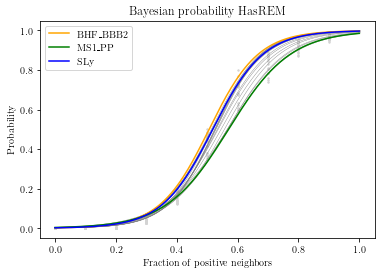

In [64]:
color_count = 0;
for eos in EOS:
    plt.scatter(n_k, EOSdic[eos]['Pbayes_REM'], s=2, c='lightgray')
    if( eos not in EOScolor): 
        plt.plot(np.linspace(0,1,200), sigmoid(np.linspace(0,1,200), *EOSdic[eos]['sigmoid_REM']), c='grey', lw=0.4)
for eos in EOScolor:
    plt.plot(np.linspace(0,1,200), sigmoid(np.linspace(0,1,200), *EOSdic[eos]['sigmoid_REM']), c=color_v[color_count], label=eos)
    color_count = color_count + 1
plt.legend()
plt.xlabel('Fraction of positive neighbors')
plt.ylabel('Probability')
plt.title('Bayesian probability HasREM')
plt.show()

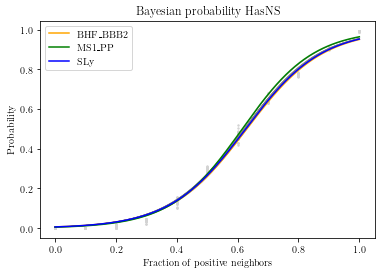

In [65]:
color_count = 0;
for eos in EOS:
    plt.scatter(n_k, EOSdic[eos]['Pbayes_NS'], s=2, c='lightgray')
    if( eos not in EOScolor): 
        plt.plot(np.linspace(0,1,200), sigmoid(np.linspace(0,1,200), *EOSdic[eos]['sigmoid_NS']), c='grey', lw=0.4)
for eos in EOScolor:
    plt.plot(np.linspace(0,1,200), sigmoid(np.linspace(0,1,200), *EOSdic[eos]['sigmoid_NS']), c=color_v[color_count], label=eos)
    color_count = color_count + 1
plt.legend()
plt.xlabel('Fraction of positive neighbors')
plt.ylabel('Probability')
plt.title('Bayesian probability HasNS')
plt.show()

In [66]:
def r2_op1(xdata, ydata, popt):
    residuals = ydata- sigmoid(xdata, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

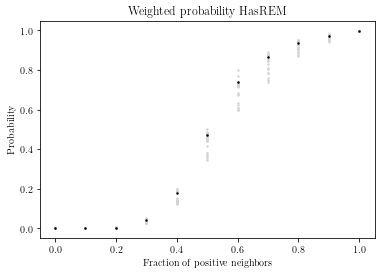

Text(0.5, 1.0, 'Weighted probability HasNS')

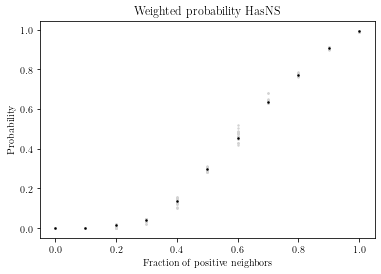

In [67]:
prob_REM = np.zeros(len(EOSdic['SLy']['Pbayes_REM']))
for eos in EOS:
    prob_REM = prob_REM + EOSdic[eos]['Pbayes_REM']*EOSdic[eos]['bayes']
prob_REM = prob_REM/sum(BayesFactor)

for eos in EOS:
    plt.scatter(n_k, EOSdic[eos]['Pbayes_REM'], s=2, c='lightgray')
plt.scatter(n_k, prob_REM, s=2, c='black')
plt.xlabel('Fraction of positive neighbors')
plt.ylabel('Probability')
plt.title('Weighted probability HasREM')
plt.show()

prob_NS = np.zeros(len(EOSdic['SLy']['Pbayes_NS']))
for eos in EOS:
    prob_NS = prob_NS + EOSdic[eos]['Pbayes_NS']*EOSdic[eos]['bayes']
prob_NS = prob_NS/sum(BayesFactor)

for eos in EOS:
    plt.scatter(n_k, EOSdic[eos]['Pbayes_NS'], s=2, c='lightgray')
plt.scatter(n_k, prob_NS, s=2, c='black')
plt.xlabel('Fraction of positive neighbors')
plt.ylabel('Probability')
plt.title('Weighted probability HasNS')

-----HasREM-----
Option 1 has residual  0.9974769298322719


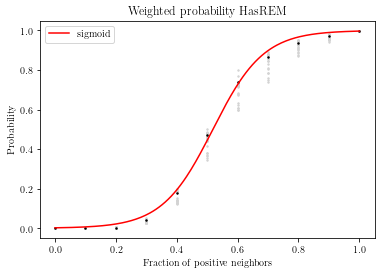

-----HasNS-----
Option 1 has residual  0.9967677952936829


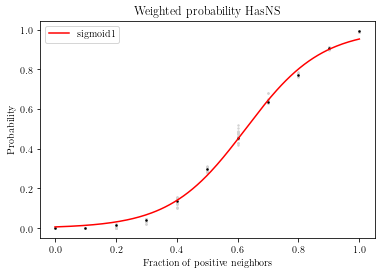

In [68]:
print("-----HasREM-----")
p0 = [np.median(n_k), 1]
popt, pcov = curve_fit(sigmoid, n_k, prob_REM, p0, method = 'lm')
a_REM, b_REM = popt
print("Option 1 has residual ", r2_op1(n_k, prob_REM, popt))

for eos in EOS:
    plt.scatter(n_k, EOSdic[eos]['Pbayes_REM'], s=2, c='lightgray')
plt.scatter(n_k, prob_REM, s=2, c='black')
plt.plot(np.linspace(0,1,200), sigmoid(np.linspace(0,1,200), a_REM, b_REM), c='red', label='sigmoid')
plt.xlabel('Fraction of positive neighbors')
plt.ylabel('Probability')
plt.title('Weighted probability HasREM')
plt.legend()
plt.show()

print("-----HasNS-----")
p0 = [np.median(n_k), 1]
popt, pcov = curve_fit(sigmoid,n_k, prob_NS, p0, method = 'lm')
a_NS, b_NS = popt
print("Option 1 has residual ", r2_op1(n_k, prob_NS, popt))
    
for eos in EOS:
    plt.scatter(n_k, EOSdic[eos]['Pbayes_NS'], s=2, c='lightgray')
plt.scatter(n_k, prob_NS, s=2, c='black')
plt.plot(np.linspace(0,1,200), sigmoid(np.linspace(0,1,200), a_NS, b_NS), c='red', label='sigmoid1')
plt.xlabel('Fraction of positive neighbors')
plt.ylabel('Probability')
plt.title('Weighted probability HasNS')
plt.legend()
plt.show()

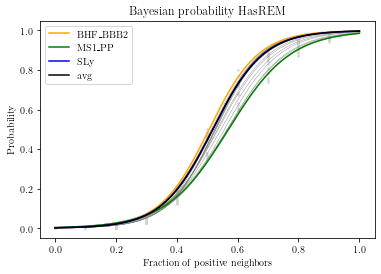

In [69]:
x_points = np.linspace(0,1,200)
prob_wa_REM = np.zeros(200)
for eos in EOS:
    prob_wa_REM = prob_wa_REM + sigmoid(x_points, *EOSdic[eos]['sigmoid_REM'])*EOSdic[eos]['bayes']
prob_wa_REM = prob_wa_REM/sum(BayesFactor)

color_count = 0;
for eos in EOS:
    plt.scatter(n_k, EOSdic[eos]['Pbayes_REM'], s=2, c='lightgray')
    if( eos not in EOScolor): 
        plt.plot(np.linspace(0,1,200), sigmoid(np.linspace(0,1,200), *EOSdic[eos]['sigmoid_REM']), c='grey', lw=0.4)
for eos in EOScolor:
    plt.plot(np.linspace(0,1,200), sigmoid(np.linspace(0,1,200), *EOSdic[eos]['sigmoid_REM']), c=color_v[color_count], label=eos)
    color_count = color_count + 1
plt.plot(np.linspace(0,1,200), prob_wa_REM, c='black',label = 'avg')
plt.legend()
plt.xlabel('Fraction of positive neighbors')
plt.ylabel('Probability')
plt.title('Bayesian probability HasREM')
plt.show()

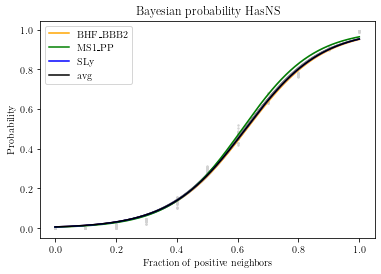

In [70]:
x_points = np.linspace(0,1,200)
prob_wa_NS = np.zeros(200)
for eos in EOS:
    prob_wa_NS = prob_wa_NS + sigmoid(x_points, *EOSdic[eos]['sigmoid_NS'])*EOSdic[eos]['bayes']
prob_wa_NS = prob_wa_NS/sum(BayesFactor)

color_count = 0;
for eos in EOS:
    plt.scatter(n_k, EOSdic[eos]['Pbayes_NS'], s=2, c='lightgray')
    if( eos not in EOScolor): 
        plt.plot(np.linspace(0,1,200), sigmoid(np.linspace(0,1,200), *EOSdic[eos]['sigmoid_NS']), c='grey', lw=0.4)
for eos in EOScolor:
    plt.plot(np.linspace(0,1,200), sigmoid(np.linspace(0,1,200), *EOSdic[eos]['sigmoid_NS']), c=color_v[color_count], label=eos)
    color_count = color_count + 1
plt.plot(np.linspace(0,1,200), prob_wa_NS, c='black',label = 'avg')
plt.legend()
plt.xlabel('Fraction of positive neighbors')
plt.ylabel('Probability')
plt.title('Bayesian probability HasNS')
plt.show()